In [1]:
!git clone https://github.com/kiritowu/Generative-Adversarial-Networks-Projects.git
%cd Generative-Adversarial-Networks-Projects/Chapter04-DCGAN

Cloning into 'Generative-Adversarial-Networks-Projects'...
remote: Enumerating objects: 1204, done.
remote: Counting objects: 100% (1103/1103), done.
remote: Compressing objects: 100% (1035/1035), done.
remote: Total 1204 (delta 114), reused 1043 (delta 65), pack-reused 101
Receiving objects: 100% (1204/1204), 1.49 GiB | 32.29 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Checking out files: 100% (980/980), done.
/content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN


In [2]:
!pip install animeface

     |████████████████████████████████| 2.8 MB 12.4 MB/s 


In [3]:
import glob
import io
import os
import math
import time

In [4]:
import animeface
import keras.backend as K
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from keras import Sequential, Input, Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Dense, ReLU, Reshape, BatchNormalization, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Activation
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing import image
from pathlib import Path
from imageio import imread, imsave
from scipy.stats import entropy

# Cropping and resizing images in dataset

In [6]:
total_num_faces = 0
raw_image_dir = str(Path(os.getcwd())/"data"/"gallery-dl"/"danbooru"/"face")
output_dir = Path(os.getcwd())/"data"/"cropped"
for index, filename in enumerate(glob.glob(raw_image_dir+'/*')):
    try:
        im = Image.open(filename)
        faces = animeface.detect(im)
    except Exception as e:
        print(f"Exception:{e}")
        continue
    
    # If no faces found in the image
    if len(faces) == 0:
        print(f"No faces found in image {filename}")
        continue
    
    fp = faces[0].face.pos

    # Get coordinates of face detected in x1, y1, x2, y2 format
    coordinates = (fp.x, fp.y, fp.x+fp.width, fp.y+fp.height)

    # Crop image
    cropped_image = im.crop(coordinates)

    # Resize Image
    cropped_image = cropped_image.resize((64,64), Image.ANTIALIAS)

    # Save to output directory
    cropped_image.save(output_dir/filename.split("/")[-1])

    total_num_faces += 1
    print(f"Number of faces detected till now: {total_num_faces}")

print(f"Total number of faces: {total_num_faces}")

No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4928663_e767c7d14dc05839c13cb320c6863763.jpg
Number of faces detected till now: 1
Number of faces detected till now: 2
Number of faces detected till now: 3
Number of faces detected till now: 4
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4942391_7b825f8853d5016d0078169e553bbb33.jpg
Number of faces detected till now: 5
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4925151_fa221192e1db0ffd422929d0c2255571.jpg
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4935905_ac9944c311d16ba1b42b8448b58a05f4.jpg
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Number of faces detected till now: 28
Number of faces detected till now: 29
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4825889_85af42b43412daa26b66e130e5a038f7.jpg
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4900882_fb2b58490dc0e0d2572efd89d7a70c28.jpg
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4815140_f6512dc0a6f1b565ee993bc9baf25e6d.jpg
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4768072_b0ee55bd0adc224beae6f72d853fe436.png
Number of faces detected till now: 30
Number of faces detected till now: 31
No faces found in image /content/Generative-Adversarial-Networks-Projects/Chapter04-DCGAN/data/gallery-dl/danbooru/face/danbooru_4774085_e683b99c3d86604

In [100]:
def build_generator():
    gen_model = Sequential()

    gen_model.add(Dense(2048, input_shape=(100,), activation='relu'))

    gen_model.add(Dense(256 * 8 * 8))
    gen_model.add(BatchNormalization())
    gen_model.add(ReLU())

    gen_model.add(Reshape((8, 8, 256), input_shape=(256 * 8 * 8,)))
    gen_model.add(UpSampling2D(size=(2, 2)))
    gen_model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))

    gen_model.add(UpSampling2D(size=(2, 2)))
    gen_model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))

    gen_model.add(UpSampling2D(size=(2, 2)))
    gen_model.add(Conv2D(3, (5, 5), padding='same', activation="tanh"))
    return gen_model


In [101]:
def build_discriminator():
    dis_model = Sequential()
    dis_model.add(
        Conv2D(128, (5, 5),
               padding='same',
               input_shape=(64, 64, 3))
    )
    dis_model.add(LeakyReLU(alpha=0.2))
    dis_model.add(MaxPooling2D(pool_size=(2, 2)))

    dis_model.add(Conv2D(256, (3, 3)))
    dis_model.add(LeakyReLU(alpha=0.2))
    dis_model.add(MaxPooling2D(pool_size=(2, 2)))

    dis_model.add(Conv2D(512, (3, 3)))
    dis_model.add(LeakyReLU(alpha=0.2))
    dis_model.add(MaxPooling2D(pool_size=(2, 2)))

    dis_model.add(Flatten())
    dis_model.add(Dense(1024))
    dis_model.add(LeakyReLU(alpha=0.2))

    dis_model.add(Dense(1))
    dis_model.add(Activation('sigmoid'))

    return dis_model


In [102]:
def build_adversarial_model(gen_model, dis_model):
    model = Sequential()
    model.add(gen_model)
    dis_model.trainable = False
    model.add(dis_model)
    return model


In [62]:
def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    writer = tf.summary.create_file_writer("/tmp/mylogs")
    with writer.as_default():
        tf.summary.scalar("loss", loss, step=batch_no)
        writer.flush()


In [11]:
def calculate_inception_score(images_path, batch_size=1, splits=10):
    # Create an instance of InceptionV3
    model = InceptionResNetV2()

    images = None
    for image_ in glob.glob(images_path):
        # Load image
        loaded_image = image.load_img(image_, target_size=(299, 299))

        # Convert PIL image to numpy ndarray
        loaded_image = image.img_to_array(loaded_image)

        # Another another dimension (Add batch dimension)
        loaded_image = np.expand_dims(loaded_image, axis=0)

        # Concatenate all images into one tensor
        if images is None:
            images = loaded_image
        else:
            images = np.concatenate([images, loaded_image], axis=0)

    # Calculate number of batches
    num_batches = (images.shape[0] + batch_size - 1) // batch_size

    probs = None

    # Use InceptionV3 to calculate probabilities
    for i in range(num_batches):
        image_batch = images[i * batch_size:(i + 1) * batch_size, :, :, :]
        prob = model.predict(preprocess_input(image_batch))

        if probs is None:
            probs = prob
        else:
            probs = np.concatenate([prob, probs], axis=0)

    # Calculate Inception scores
    divs = []
    split_size = probs.shape[0] // splits

    for i in range(splits):
        prob_batch = probs[(i * split_size):((i + 1) * split_size), :]
        p_y = np.expand_dims(np.mean(prob_batch, 0), 0)
        div = prob_batch * (np.log(prob_batch / p_y))
        div = np.mean(np.sum(div, 1))
        divs.append(np.exp(div))

    return np.mean(divs), np.std(divs)


def calculate_mode_score(gen_images_path, real_images_path, batch_size=32, splits=10):
    # Create an instance of InceptionV3
    model = InceptionResNetV2()

    # Load real images
    real_images = None
    for image_ in glob.glob(real_images_path):
        # Load image
        loaded_image = image.load_img(image_, target_size=(299, 299))

        # Convert PIL image to numpy ndarray
        loaded_image = image.img_to_array(loaded_image)

        # Another another dimension (Add batch dimension)
        loaded_image = np.expand_dims(loaded_image, axis=0)

        # Concatenate all images into one tensor
        if real_images is None:
            real_images = loaded_image
        else:
            real_images = np.concatenate([real_images, loaded_image], axis=0)

    # Load generated images
    gen_images = None
    for image_ in glob.glob(gen_images_path):
        # Load image
        loaded_image = image.load_img(image_, target_size=(299, 299))

        # Convert PIL image to numpy ndarray
        loaded_image = image.img_to_array(loaded_image)

        # Another another dimension (Add batch dimension)
        loaded_image = np.expand_dims(loaded_image, axis=0)

        # Concatenate all images into one tensor
        if gen_images is None:
            gen_images = loaded_image
        else:
            gen_images = np.concatenate([gen_images, loaded_image], axis=0)

    # Calculate number of batches for generated images
    gen_num_batches = (gen_images.shape[0] + batch_size - 1) // batch_size
    gen_images_probs = None
    # Use InceptionV3 to calculate probabilities of generated images
    for i in range(gen_num_batches):
        image_batch = gen_images[i * batch_size:(i + 1) * batch_size, :, :, :]
        prob = model.predict(preprocess_input(image_batch))

        if gen_images_probs is None:
            gen_images_probs = prob
        else:
            gen_images_probs = np.concatenate([prob, gen_images_probs], axis=0)

    # Calculate number of batches for real images
    real_num_batches = (real_images.shape[0] + batch_size - 1) // batch_size
    real_images_probs = None
    # Use InceptionV3 to calculate probabilities of real images
    for i in range(real_num_batches):
        image_batch = real_images[i * batch_size:(i + 1) * batch_size, :, :, :]
        prob = model.predict(preprocess_input(image_batch))

        if real_images_probs is None:
            real_images_probs = prob
        else:
            real_images_probs = np.concatenate([prob, real_images_probs], axis=0)

    # KL-Divergence: compute kl-divergence and mean of it
    num_gen_images = len(gen_images)
    split_scores = []

    for j in range(splits):
        gen_part = gen_images_probs[j * (num_gen_images // splits): (j + 1) * (num_gen_images // splits), :]
        real_part = real_images_probs[j * (num_gen_images // splits): (j + 1) * (num_gen_images // splits), :]
        gen_py = np.mean(gen_part, axis=0)
        real_py = np.mean(real_part, axis=0)
        scores = []
        for i in range(gen_part.shape[0]):
            scores.append(entropy(gen_part[i, :], gen_py))

        split_scores.append(np.exp(np.mean(scores) - entropy(gen_py, real_py)))

    final_mean = np.mean(split_scores)
    final_std = np.std(split_scores)

    return final_mean, final_std


In [12]:
def denormalize(img):
    img = (img + 1) * 127.5
    return img.astype(np.uint8)


def normalize(img):
    return (img - 127.5) / 127.5


def visualize_rgb(img):
    """
    Visualize a rgb image
    :param img: RGB image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")
    plt.show()


def save_rgb_img(img, path):
    """
    Save a rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("RGB Image")

    plt.savefig(path)
    plt.close()


In [127]:
start_time = time.time()
dataset_dir = str(output_dir)+"/*"
batch_size = 128
z_shape = 100
epochs = 10000
dis_learning_rate = 0.005
gen_learning_rate = 0.005
dis_momentum = 0.5
gen_momentum = 0.5
dis_nesterov = True
gen_nesterov = True

dis_optimizer = SGD(lr=dis_learning_rate, momentum=dis_momentum, nesterov=dis_nesterov)
gen_optimizer = SGD(lr=gen_learning_rate, momentum=gen_momentum, nesterov=gen_nesterov)

# Load images
all_images = [imread(filename) for filename in glob.glob(dataset_dir) if imread(filename).shape == (64, 64, 3)]

X = np.array(all_images)
X = (X - 127.5) / 127.5
X = X.astype(np.float32)
X = X + np.random.randn(*X.shape)

dis_model = build_discriminator()
dis_model.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

gen_model = build_generator()
gen_model.compile(loss='mse', optimizer=gen_optimizer)

adversarial_model = build_adversarial_model(gen_model, dis_model)
adversarial_model.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()), write_images=True, write_grads=True, write_graph=True)
tensorboard.set_model(gen_model)
tensorboard.set_model(dis_model)

for epoch in range(epochs):
    print("--------------------------")
    print("Epoch:{}".format(epoch))

    dis_losses = []
    gen_losses = []

    num_batches = int(X.shape[0] / batch_size)

    print("Number of batches:{}".format(num_batches))
    for index in range(num_batches):
        print("Batch:{}".format(index))

        z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
        # z_noise = np.random.uniform(-1, 1, size=(batch_size, 100))

        generated_images = gen_model.predict_on_batch(z_noise)

        # visualize_rgb(generated_images[0])

        """
        Train the discriminator model
        """

        dis_model.trainable = True

        image_batch = X[index * batch_size:(index + 1) * batch_size]

        y_real = np.ones((batch_size, )) * 0.8
        y_fake = np.zeros((batch_size, )) * 0.2

        dis_loss_real = dis_model.train_on_batch(image_batch, y_real)
        dis_loss_fake = dis_model.train_on_batch(generated_images, y_fake)

        d_loss = (dis_loss_real+dis_loss_fake)/2
        print("d_loss:", d_loss)

        dis_model.trainable = False

        """
        Train the generator model(adversarial model)
        """
        z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
        # z_noise = np.random.uniform(-1, 1, size=(batch_size, 100))

        g_loss = adversarial_model.train_on_batch(z_noise, y_real)
        print("g_loss:", g_loss)

        dis_losses.append(d_loss)
        gen_losses.append(g_loss)

    """
    Sample some images and save them
    """
    if epoch % 100 == 0:
        z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
        gen_images1 = gen_model.predict_on_batch(z_noise)

        for img in gen_images1[:2]:
            save_rgb_img(denormalize(img), "results/one_{}.png".format(epoch))

    print("Epoch:{}, dis_loss:{}".format(epoch, np.mean(dis_losses)))
    print("Epoch:{}, gen_loss: {}".format(epoch, np.mean(gen_losses)))

    """
    Save losses to Tensorboard after each epoch
    """
    write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
    write_log(tensorboard, 'generator_loss', np.mean(gen_losses), epoch)

"""
Save models
"""
gen_model.save("generator_model.h5")
dis_model.save("generator_model.h5")

print("Time:", (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


--------------------------
Epoch:0
Number of batches:2
Batch:0
d_loss: 0.6606096029281616
g_loss: 0.6211951971054077
Batch:1
d_loss: 0.6038093268871307
g_loss: 0.6260620355606079
Epoch:0, dis_loss:0.6322094649076462
Epoch:0, gen_loss: 0.6236286163330078
--------------------------
Epoch:1
Number of batches:2
Batch:0
d_loss: 0.5989037156105042
g_loss: 0.6343166828155518
Batch:1
d_loss: 0.594289630651474
g_loss: 0.639510989189148
Epoch:1, dis_loss:0.5965966731309891
Epoch:1, gen_loss: 0.6369138360023499
--------------------------
Epoch:2
Number of batches:2
Batch:0
d_loss: 0.5904021263122559
g_loss: 0.643366813659668
Batch:1
d_loss: 0.5864177346229553
g_loss: 0.6467748880386353
Epoch:2, dis_loss:0.5884099304676056
Epoch:2, gen_loss: 0.6450708508491516
--------------------------
Epoch:3
Number of batches:2
Batch:0
d_loss: 0.5827219784259796
g_loss: 0.6499286890029907
Batch:1
d_loss: 0.5789272785186768
g_loss: 0.6536714434623718
Epoch:3, dis_loss:0.5808246284723282
Epoch:3, gen_loss: 0.6518

KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


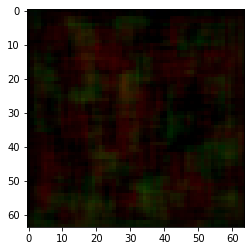

In [128]:
z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
gen_images1 = gen_model.predict_on_batch(z_noise)
plt.imshow(gen_images1[0])
# gen_images1[0].shape

In [123]:
image_batch[5]

array([[[ 0.6627451 ,  0.3882353 ,  0.23921569],
        [ 0.654902  ,  0.38039216,  0.23137255],
        [ 0.6392157 ,  0.3647059 ,  0.21568628],
        ...,
        [ 0.52156866,  0.23921569,  0.12941177],
        [ 0.3254902 ,  0.04313726, -0.06666667],
        [ 0.30980393,  0.02745098, -0.08235294]],

       [[ 0.6627451 ,  0.3882353 ,  0.23921569],
        [ 0.6313726 ,  0.35686275,  0.20784314],
        [ 0.6313726 ,  0.35686275,  0.20784314],
        ...,
        [ 0.5294118 ,  0.24705882,  0.13725491],
        [ 0.34117648,  0.05882353, -0.05098039],
        [ 0.34901962,  0.06666667, -0.04313726]],

       [[ 0.6627451 ,  0.3882353 ,  0.23921569],
        [ 0.6       ,  0.3254902 ,  0.1764706 ],
        [ 0.60784316,  0.33333334,  0.18431373],
        ...,
        [ 0.5372549 ,  0.25490198,  0.14509805],
        [ 0.34901962,  0.06666667, -0.04313726],
        [ 0.35686275,  0.07450981, -0.03529412]],

       ...,

       [[ 0.7882353 ,  0.5529412 ,  0.49019608],
        [ 0